PCP Radiomic Classifier Simulation

In [1]:
# %% Setup and Import
import numpy as np
from scipy.stats import lognorm, gaussian_kde
from scipy.optimize import minimize
from scipy.stats import truncnorm
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.metrics import roc_auc_score, roc_curve
import ipywidgets as widgets
from ipywidgets import HBox, VBox, Layout, interactive_output
from traitlets import link
from scipy.stats import gaussian_kde
import pandas as pd
from scipy.special import expit, logit


np.random.seed(123)

In [2]:
# %% Literature definitions for nodule distributions
# Gould-style bins for largest nodule, 4–30 mm
edges = np.array([4, 5, 8, 12, 20, 30])

# Target proportions in each bin (conditional on 4–30 mm)
target_props = np.array([0.26, 0.24, 0.18, 0.22, 0.10])

In [3]:
def truncated_lognorm_bin_probs(mu, log_sigma, edges):
    """
    Given meanlog=mu and log_sigma=log(sigma),
    return conditional bin probabilities over [edges[0], edges[-1]].
    """
    sigma = np.exp(log_sigma)
    dist = lognorm(s=sigma, scale=np.exp(mu))

    F_edges = dist.cdf(edges)

    # Normalizing constant over [4,30]
    Z = F_edges[-1] - F_edges[0]

    # Mirror the R behavior: if essentially zero mass in [4,30], kill it
    if (not np.isfinite(Z)) or (Z < 1e-6):
        return np.full(len(edges) - 1, np.nan)

    p_bins = np.diff(F_edges) / Z
    return p_bins


def objective(params, edges, target_props):
    mu, log_sigma = params
    p_bins = truncated_lognorm_bin_probs(mu, log_sigma, edges)
    if np.any(~np.isfinite(p_bins)):
        return 1e6
    return np.sum((p_bins - target_props) ** 2)


In [4]:
from scipy.optimize import minimize

mu_init = 2.3
log_sigma_init = np.log(0.6)

res = minimize(
    objective,
    x0=np.array([mu_init, log_sigma_init]),
    args=(edges, target_props),
    method="L-BFGS-B",
    bounds=[(1, 3.0), (np.log(.2), np.log(1.5))],  # bounds on mu, log_sigma
    options={"maxiter": 2000, "disp": True}
)

mu_hat, log_sigma_hat = res.x
sigma_hat = np.exp(log_sigma_hat)

print("Fitted parameters:")
print(f"  meanlog (mu_hat)   = {mu_hat:.4f}")
print(f"  sdlog  (sigma_hat) = {sigma_hat:.4f}")

p_fit = truncated_lognorm_bin_probs(mu_hat, log_sigma_hat, edges)

# print("\nBin matches (target vs fit):")
# for i in range(len(target_props)):
#     print(
#         f"{edges[i]:>2.0f}–{edges[i+1]:<2.0f} mm: "
#         f"target = {target_props[i]:.3f},  fit = {p_fit[i]:.3f}"
#     )


Fitted parameters:
  meanlog (mu_hat)   = 1.0000
  sdlog  (sigma_hat) = 1.5000


In [5]:
# %%
mu_hat, log_sigma_hat = res.x
sigma_hat = np.exp(log_sigma_hat)

#print("Fitted parameters:")
#print(f"  meanlog (mu_hat)   = {mu_hat:.4f}")
#print(f"  sdlog  (sigma_hat) = {sigma_hat:.4f}")

p_fit = truncated_lognorm_bin_probs(mu_hat, log_sigma_hat, edges)

#print("\nBin matches (target vs fit):")
#for i in range(len(target_props)):
#    print(
#        f"{edges[i]:>2.0f}–{edges[i+1]:<2.0f} mm: "
#        f"target = {target_props[i]:.3f},  fit = {p_fit[i]:.3f}"
#    )


In [6]:
# %%
def r_truncated_lognorm(n, meanlog, sdlog, xmin=4.0, xmax=30.0):
    """
    Fast truncated lognormal sampler:
    log(X) ~ N(meanlog, sdlog^2), truncated to [log(xmin), log(xmax)].
    """
    # sanity check: interval has non-negligible probability
    dist_full = lognorm(s=sdlog, scale=np.exp(meanlog))
    p_int = dist_full.cdf(xmax) - dist_full.cdf(xmin)
    if (not np.isfinite(p_int)) or (p_int < 1e-8):
        raise ValueError(
            f"Truncation [{xmin}, {xmax}] has essentially zero prob (p={p_int:.2e}) "
            f"under lognormal(meanlog={meanlog:.3f}, sdlog={sdlog:.3f})."
        )
    
    # transform to standard normal on log-scale
    a = (np.log(xmin) - meanlog) / sdlog
    b = (np.log(xmax) - meanlog) / sdlog
    
    # sample Z ~ N(0,1) truncated to [a,b]
    z = truncnorm.rvs(a, b, loc=0, scale=1, size=n)
    return np.exp(meanlog + sdlog * z)


In [10]:
# %%
N_all = 100000  # total PCP-world nodules (choose scale)

size_all = r_truncated_lognorm(
    n=N_all,
    meanlog=mu_hat,
    sdlog=sigma_hat,
    xmin=4.0,
    xmax=30.0
)

size_all_orig = size_all.copy()  # keep full PCP pool


In [11]:
# %%
N_lit = 10000

# choose bin index for each literature nodule
bin_ids = np.random.choice(
    np.arange(len(target_props)),
    size=N_lit,
    p=target_props
)

size_lit = np.empty(N_lit)
for i, b in enumerate(bin_ids):
    low = edges[b]
    high = edges[b + 1]
    size_lit[i] = np.random.uniform(low, high)

size_lit[:10]


array([ 4.66903197,  4.033676  , 20.62639597, 12.29027988,  7.42006789,
       10.57960148,  4.58444485,  8.3155927 ,  4.12637637,  5.06751856])

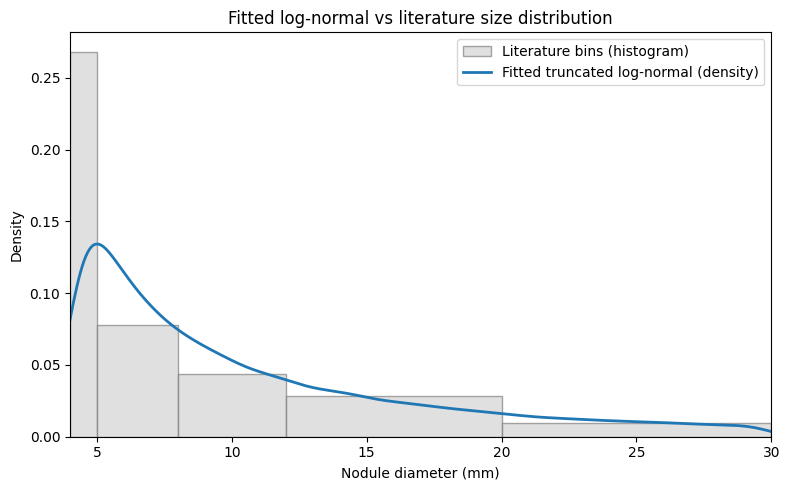

In [12]:
# %%
plt.figure(figsize=(8, 5))

# Literature histogram as density
plt.hist(
    size_lit,
    bins=edges,
    density=True,
    alpha=0.7,
    color="lightgray",
    edgecolor="gray",
    label="Literature bins (histogram)"
)

# Simulated density using KDE
kde = gaussian_kde(size_all)
x_vals = np.linspace(4, 30, 400)
y_vals = kde(x_vals)

plt.plot(
    x_vals,
    y_vals,
    linewidth=2,
    label="Fitted truncated log-normal (density)"
)

plt.xlabel("Nodule diameter (mm)")
plt.ylabel("Density")
plt.title("Fitted log-normal vs literature size distribution")
plt.xlim(4, 30)
plt.legend()
plt.tight_layout()
plt.show()


In [22]:
# %%


# Literature / size bins: same as before
breaks_lit = np.array([4, 5, 8, 12, 20, 30])

# Malignancy probability per bin (R: probs_malig_lit)
probs_malig_lit = np.array([
    0.01,  # 4–<=5 mm
    0.03,  # >5–<=8 mm
    0.07,  # >8–<=12 mm
    0.15,  # >12–<=20 mm
    0.30   # >20–<=30 mm
])

probs_malig_lit = probs_malig_lit/1.76

assert len(probs_malig_lit) == len(breaks_lit) - 1

def malig_prob_from_size(size_mm):
    """
    Vectorized: assign malignancy probability by size bin.
    Out-of-range gets 0.
    """
    size_mm = np.asarray(size_mm)
    probs = np.zeros_like(size_mm, dtype=float)

    # bins: [4,5], (5,8], (8,12], (12,20], (20,30]
    for i in range(len(probs_malig_lit)):
        low = breaks_lit[i]
        high = breaks_lit[i+1]
        if i == 0:
            mask = (size_mm >= low) & (size_mm <= high)
        else:
            mask = (size_mm > low) & (size_mm <= high)
        probs[mask] = probs_malig_lit[i]

    return probs

# For all nodules in PCP pool:
p_all = malig_prob_from_size(size_all_orig)
rng = np.random.default_rng(123)

cancer_all = rng.binomial(1, p_all, size=len(size_all_orig))


In [23]:
# %%
# Clip probabilities to avoid logit(0) / logit(1)
p_eps = np.clip(p_all, 1e-6, 1 - 1e-6)
Mayo_log = logit(p_eps)

sim_data = pd.DataFrame({
    "y": cancer_all.astype(int),
    "Mayo_log": Mayo_log,
    "size_mm": size_all_orig
})



In [24]:
# %%
RAD_Perf = "smallnodules"  # "low", "med", "high", "smallnodules"
RAD_mode = "Sens"          # "Balanced", "Spec", "Sens"

# Base AUC tuning (same as R)
if RAD_Perf == "low":
    AUCnew = 0.73211 - 0.071
elif RAD_Perf == "med":
    AUCnew = 0.73211
elif RAD_Perf == "high":
    AUCnew = 0.73211 + 0.071
elif RAD_Perf == "smallnodules":
    AUCnew = 0.90
else:
    AUCnew = 0.73211

# Solve for pooled SD assuming sigma0 = sigma1  (same formula as R)
z = norm.ppf(AUCnew)
pooled_sd = 1.0 / (np.sqrt(2.0) * z)

SD_radiomics = pooled_sd          # base SD
rad_rho = 0.2                     # correlation with Mayo_log, as in R

y = sim_data["y"].values.astype(int)
X_log = sim_data["Mayo_log"].values

rng = np.random.default_rng(456)
Radiomics = np.zeros_like(X_log, dtype=float)

for grp in [0, 1]:
    idx = (y == grp)
    if not np.any(idx):
        continue

    X = X_log[idx]
    mu_x = X.mean()
    sd_x = X.std()
    Z_x = (X - mu_x) / sd_x   # standardized Mayo_log

    # Adjust SD and tail behavior by RAD_mode and group (mirroring R)
    if RAD_mode == "Balanced":
        group_sd = SD_radiomics
        def tail_fn(n, sd=group_sd):
            return rng.normal(0.0, sd, size=n)

    elif RAD_mode == "Spec" and grp == 0:
        group_sd = SD_radiomics * 0.85  # tighter controls
        def tail_fn(n, sd=group_sd):
            return rng.normal(0.0, sd, size=n)

    elif RAD_mode == "Spec" and grp == 1:
        group_sd = SD_radiomics * 1.5
        # heavy tails: t(df=3) scaled to sd = group_sd
        def tail_fn(n, sd=group_sd):
            t_raw = rng.standard_t(df=3, size=n)
            return t_raw * (sd / np.sqrt(3.0))

    elif RAD_mode == "Sens" and grp == 1:
        group_sd = SD_radiomics * 0.7   # tighter cases
        def tail_fn(n, sd=group_sd):
            return rng.normal(0.0, sd, size=n)

    elif RAD_mode == "Sens" and grp == 0:
        group_sd = SD_radiomics * 1.65
        def tail_fn(n, sd=group_sd):
            t_raw = rng.standard_t(df=3, size=n)
            return t_raw * (sd / np.sqrt(3.0))

    else:
        # Fallback
        group_sd = SD_radiomics
        def tail_fn(n, sd=group_sd):
            return rng.normal(0.0, sd, size=n)

    # Generate noise and correlated radiomics component
    eps = tail_fn(idx.sum())
    R = rad_rho * group_sd * Z_x + np.sqrt(1.0 - rad_rho**2) * eps

    # Center to desired mean (0 for controls, 1 for cases)
    mu_r = float(grp)
    Radiomics[idx] = R - R.mean() + mu_r

# Use Radiomics as the continuous score (ROC is invariant to monotone transforms)
sim_data["Radiomics"] = Radiomics

#print("Radiomics AUC in PCP population:",
#      roc_auc_score(sim_data["y"], sim_data["Radiomics"]))
#print("Target AUCnew:", AUCnew)


In [25]:
# %%


def get_rad_operating_point(y, scores, sens_target):
    """
    Approximate coords(..., x = sens_target, input = 'sensitivity').
    Returns dict with sensitivity, specificity, threshold.
    """
    fpr, tpr, thresholds = roc_curve(y, scores)

    # pick threshold with sensitivity closest to target
    idx = np.argmin(np.abs(tpr - sens_target))

    sens = tpr[idx]
    spec = 1 - fpr[idx]
    thr  = thresholds[idx]

    return {
        "sensitivity": sens,
        "specificity": spec,
        "threshold": thr
    }

# single point example ~0.98 sens
op_98 = get_rad_operating_point(sim_data["y"].values,
                                sim_data["Radiomics"].values,
                                sens_target=0.98)

sens_rad = op_98["sensitivity"]
spec_rad = op_98["specificity"]

sens_rad, spec_rad

# %%
sens_grid = np.arange(0.80, 1.00 + 1e-8, 0.01)

ops = []
y_arr = sim_data["y"].values
scores_arr = sim_data["Radiomics"].values

for s in sens_grid:
    op = get_rad_operating_point(y_arr, scores_arr, sens_target=s)
    ops.append({
        "sens_target": s,
        "sensitivity": op["sensitivity"],
        "specificity": op["specificity"]
    })

op_grid = pd.DataFrame(ops)

op_grid["FNR"] = 1 - op_grid["sensitivity"]

N_cancer = (y_arr == 1).sum()
N_benign = (y_arr == 0).sum()

op_grid["Prev_pos"] = (op_grid["sensitivity"] * N_cancer) / (
    op_grid["sensitivity"] * N_cancer +
    (1 - op_grid["specificity"]) * N_benign
)

op_grid["Prev_neg"] = ((1 - op_grid["sensitivity"]) * N_cancer) / (
    (1 - op_grid["sensitivity"]) * N_cancer +
    op_grid["specificity"] * N_benign
)

#op_grid.head()


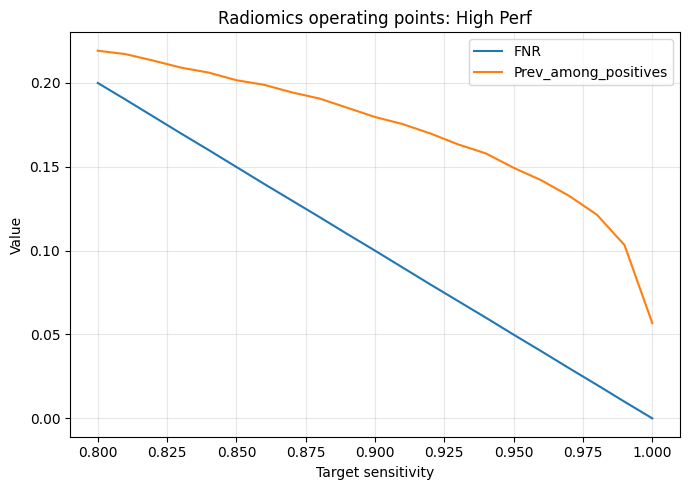

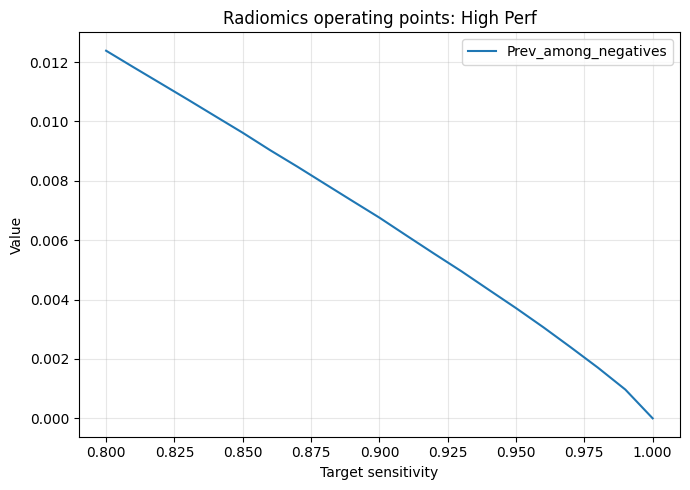

In [26]:
# %%
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
plt.plot(op_grid["sens_target"], op_grid["FNR"], label="FNR", linewidth=1.5)
plt.plot(op_grid["sens_target"], op_grid["Prev_pos"], label="Prev_among_positives", linewidth=1.5)
plt.xlabel("Target sensitivity")
plt.ylabel("Value")
plt.title("Radiomics operating points: High Perf")
plt.legend(loc="upper right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,5))
plt.plot(op_grid["sens_target"], op_grid["Prev_neg"], label="Prev_among_negatives", linewidth=1.5)
plt.xlabel("Target sensitivity")
plt.ylabel("Value")
plt.title("Radiomics operating points: High Perf")
plt.legend(loc="upper right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


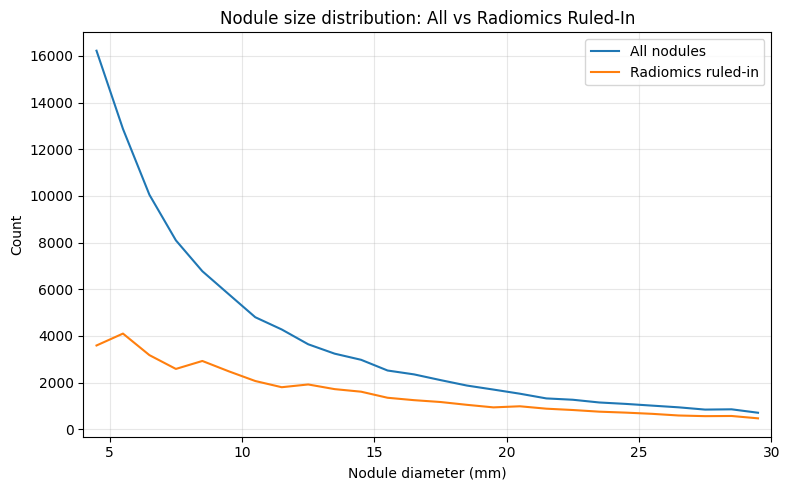

In [27]:
# %%
# Radiomics positive if score >= threshold at some chosen sens_target, e.g. 0.98
thr_98 = op_98["threshold"]
test_pos = scores_arr >= thr_98

df_all = pd.DataFrame({
    "size_mm": size_all_orig,
    "group": "All nodules"
})

df_in = pd.DataFrame({
    "size_mm": size_all_orig[test_pos],
    "group": "Radiomics ruled-in"
})

df_den = pd.concat([df_all, df_in], ignore_index=True)

plt.figure(figsize=(8,5))
for group, df_g in df_den.groupby("group"):
    counts, bin_edges = np.histogram(df_g["size_mm"], bins=np.arange(4, 31, 1))
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    plt.plot(bin_centers, counts, label=group, linewidth=1.5)

plt.xlabel("Nodule diameter (mm)")
plt.ylabel("Count")
plt.title("Nodule size distribution: All vs Radiomics Ruled-In")
plt.xlim(4, 30)
plt.legend(loc="upper right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [28]:
# Radiomics generator consistent with R code
from scipy.stats import norm
from sklearn.metrics import roc_auc_score, roc_curve
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def generate_radiomics(sim_data, RAD_Perf="smallnodules", RAD_mode="Sens",
                       rad_rho=0.2, rng_seed=456):
    """
    Given sim_data with columns y (0/1) and Mayo_log,
    generate a Radiomics score column following your R rules.
    """
    y = sim_data["y"].values.astype(int)
    X_log = sim_data["Mayo_log"].values

    # --- AUC dial ---
    if RAD_Perf == "low":
        AUCnew = 0.73211 - 0.071
    elif RAD_Perf == "med":
        AUCnew = 0.73211
    elif RAD_Perf == "high":
        AUCnew = 0.73211 + 0.071
    elif RAD_Perf == "smallnodules":
        AUCnew = 0.90
    else:
        AUCnew = 0.73211

    # pooled SD from AUC (same as R)
    z = norm.ppf(AUCnew)
    pooled_sd = 1.0 / (np.sqrt(2.0) * z)

    SD_radiomics = pooled_sd
    rad_rho = rad_rho

    rng = np.random.default_rng(rng_seed)
    Radiomics = np.zeros_like(X_log, dtype=float)

    for grp in [0, 1]:
        idx = (y == grp)
        if not np.any(idx):
            continue

        X = X_log[idx]
        mu_x = X.mean()
        sd_x = X.std()
        Z_x = (X - mu_x) / sd_x

        # RAD_mode behavior
        if RAD_mode == "Balanced":
            group_sd = SD_radiomics
            def tail_fn(n, sd=group_sd):
                return rng.normal(0.0, sd, size=n)

        elif RAD_mode == "Spec" and grp == 0:
            group_sd = SD_radiomics * 0.85
            def tail_fn(n, sd=group_sd):
                return rng.normal(0.0, sd, size=n)

        elif RAD_mode == "Spec" and grp == 1:
            group_sd = SD_radiomics * 1.5
            def tail_fn(n, sd=group_sd):
                t_raw = rng.standard_t(df=3, size=n)
                return t_raw * (sd / np.sqrt(3.0))

        elif RAD_mode == "Sens" and grp == 1:
            group_sd = SD_radiomics * 0.7
            def tail_fn(n, sd=group_sd):
                return rng.normal(0.0, sd, size=n)

        elif RAD_mode == "Sens" and grp == 0:
            group_sd = SD_radiomics * 1.65
            def tail_fn(n, sd=group_sd):
                t_raw = rng.standard_t(df=3, size=n)
                return t_raw * (sd / np.sqrt(3.0))

        else:
            # fallback
            group_sd = SD_radiomics
            def tail_fn(n, sd=group_sd):
                return rng.normal(0.0, sd, size=n)

        eps = tail_fn(idx.sum())
        R = rad_rho * group_sd * Z_x + np.sqrt(1.0 - rad_rho**2) * eps

        mu_r = float(grp)  # mean 0 for controls, 1 for cases
        Radiomics[idx] = R - R.mean() + mu_r

    sim_data = sim_data.copy()
    sim_data["Radiomics"] = Radiomics

    auc = roc_auc_score(sim_data["y"], sim_data["Radiomics"])
    return sim_data, auc


In [29]:
def get_operating_point(y, scores, sens_target):
    fpr, tpr, thresholds = roc_curve(y, scores)
    idx = np.argmin(np.abs(tpr - sens_target))
    sens = tpr[idx]
    spec = 1 - fpr[idx]
    thr  = thresholds[idx]
    return {"sensitivity": sens, "specificity": spec, "threshold": thr}

def sweep_sensitivity(sim_data, sens_min=0.80, sens_max=1.00, step=0.01):
    y = sim_data["y"].values
    scores = sim_data["Radiomics"].values

    sens_grid = np.arange(sens_min, sens_max + 1e-8, step)
    N_cancer = (y == 1).sum()
    N_benign = (y == 0).sum()

    rows = []
    for s in sens_grid:
        op   = get_operating_point(y, scores, s)
        sens = op["sensitivity"]
        spec = op["specificity"]
        thr  = op["threshold"]

        FNR = 1 - sens
        Prev_pos = (sens * N_cancer) / (sens * N_cancer + (1 - spec) * N_benign)
        Prev_neg = ((1 - sens) * N_cancer) / ((1 - sens) * N_cancer + spec * N_benign)

        rows.append({
            "sens_target": s,
            "sensitivity": sens,
            "specificity": spec,
            "FNR": FNR,
            "Prev_pos": Prev_pos,
            "Prev_neg": Prev_neg,
            "threshold": thr      # ← NEW
        })

    return pd.DataFrame(rows)



In [32]:
##### import ipywidgets as widgets
from ipywidgets import HBox, VBox, Layout, interactive_output

# Widgets
rad_perf_widget = widgets.Dropdown(
    options=[("Low", "low"), ("Medium", "med"), ("High", "high"), ("Small nodules", "smallnodules")],
    value="smallnodules",
    description="RAD Perf:"
)

rad_mode_widget = widgets.Dropdown(
    options=[("Balanced", "Balanced"), ("Sensitivity-focused", "Sens"), ("Specificity-focused", "Spec")],
    value="Sens",
    description="RAD Mode:"
)

target_sens_widget = widgets.FloatSlider(
    value=0.95, min=0.70, max=1.0, step=0.01,
    description="Target sens:", readout_format=".2f"
)

size_cut_widget = widgets.FloatSlider(
    value=6.0, min=4.0, max=30.0, step=0.5,
    description="Size cut (mm):", readout_format=".1f"
)

n_display_widget = widgets.IntText(
    value=len(sim_data),
    description="N PCP:",
    disabled=True
)

def run_app(RAD_Perf, RAD_Mode, target_sens, size_cut):
    # 1) generate radiomics
    sim_with_rad, auc_rad = generate_radiomics(sim_data, RAD_Perf=RAD_Perf, RAD_mode=RAD_Mode)


    # (You can keep sweep_sensitivity if you still use it elsewhere, otherwise omit)
    op_grid = sweep_sensitivity(sim_with_rad, sens_min=0.70, sens_max=0.98, step=0.01)

    # --- Prepare data ---
    y_true     = sim_with_rad["y"].values.astype(int)
    scores_rad = sim_with_rad["Radiomics"].values
    size_vals  = sim_with_rad["size_mm"].values

    # Find the row in op_grid closest to the target sensitivity
    idx_grid = np.argmin(np.abs(op_grid["sens_target"] - target_sens))
    op_row = op_grid.iloc[idx_grid]

    thr       = op_row["threshold"]
    sens_eff  = op_row["sens_target"]   # actual sensitivity at this threshold
    fnr_at    = op_row["FNR"]
    prev_pos_at = op_row["Prev_pos"]
    prev_neg_at = op_row["Prev_neg"]

    # --- ROC for Radiomics and Size ---
    fpr_rad, tpr_rad, thr_rad = roc_curve(y_true, scores_rad)
    auc_rad = roc_auc_score(y_true, scores_rad)

    fpr_size, tpr_size, thr_size = roc_curve(y_true, size_vals)
    auc_size = roc_auc_score(y_true, size_vals)

    # --- Find threshold at target sensitivity (Radiomics) ---
    idx_target = np.argmin(np.abs(tpr_rad - target_sens))
    thr = thr_rad[idx_target]

    # Apply threshold
    pred_pos = scores_rad >= thr
    pred_neg = ~pred_pos

    TP = np.sum(pred_pos & (y_true == 1))
    FP = np.sum(pred_pos & (y_true == 0))
    FN = np.sum(pred_neg & (y_true == 1))
    TN = np.sum(pred_neg & (y_true == 0))

    sens = TP / (TP + FN) if (TP + FN) > 0 else np.nan
    spec = TN / (TN + FP) if (TN + FP) > 0 else np.nan


    # Rule-in / rule-out group stats for Radiomics
    n_rulein  = np.sum(pred_pos)
    n_ruleout = np.sum(pred_neg)

    prev_rulein  = TP / n_rulein  if n_rulein  > 0 else np.nan
    prev_ruleout = FN / n_ruleout if n_ruleout > 0 else np.nan

    # Size-based groups
    mask_large = size_vals > size_cut
    mask_small = ~mask_large

    n_large = np.sum(mask_large)
    n_small = np.sum(mask_small)

    prev_large = y_true[mask_large].mean() if n_large > 0 else np.nan
    prev_small = y_true[mask_small].mean() if n_small > 0 else np.nan

    

    # --- Single dashboard figure: 2 rows x 3 columns ---
    fig = plt.figure(figsize=(14, 8))
    gs = fig.add_gridspec(
        2, 3,
        height_ratios=[1, 1.1],
        width_ratios=[1, 1, 1.2]
    )

    # ===== Row 1, Col 1: ROC (Radiomics vs Size) =====
    ax_roc = fig.add_subplot(gs[0, 0])

    ax_roc.plot(fpr_rad, tpr_rad, lw=2, label=f"Radiomics (AUC = {auc_rad:.2f})")
    ax_roc.plot(fpr_size, tpr_size, lw=2, linestyle="--", label=f"Size (AUC = {auc_size:.2f})")
    ax_roc.plot([0, 1], [0, 1], linestyle=":")

    # Dot and horizontal line at the chosen operating point
    idx_thr = np.argmin(np.abs(thr_rad - thr))
    x_dot = fpr_rad[idx_thr]
    y_dot = tpr_rad[idx_thr]

    ax_roc.axhline(sens_eff, linestyle="--", alpha=0.5)
    ax_roc.plot(x_dot, y_dot, "o", markersize=6)

    ax_roc.set_xlabel("1 - Specificity")
    ax_roc.set_ylabel("Sensitivity")
    ax_roc.set_title("ROC: Radiomics vs Nodule Size")
    ax_roc.legend(loc="lower right")

    # ===== Row 1, Col 2-3: size density by outcome =====
    ax_dist = fig.add_subplot(gs[0, 1:3])

    size_cancer  = size_vals[y_true == 1]
    size_control = size_vals[y_true == 0]

    # Optional: keep hist
    ax_dist.hist(size_control, bins=30, density=True, alpha=0.3, label="Benign (hist)")
    ax_dist.hist(size_cancer,  bins=30, density=True, alpha=0.3, label="Cancer (hist)")

    # Smoothed KDE curves
    kde_control = gaussian_kde(size_control)
    kde_cancer  = gaussian_kde(size_cancer)
    x_vals = np.linspace(size_vals.min(), size_vals.max(), 300)

    ax_dist.plot(x_vals, kde_control(x_vals), linewidth=2, alpha=0.9, label="Benign (KDE)")
    ax_dist.plot(x_vals, kde_cancer(x_vals),  linewidth=2, alpha=0.9, label="Cancer (KDE)")

    ax_dist.set_xlabel("Nodule size (mm)")
    ax_dist.set_ylabel("Density")
    ax_dist.set_title("Nodule size distribution by outcome")
    ax_dist.legend()

    # ===== Row 2, Col 1: FNR + Prev_pos vs sensitivity =====
    ax_fnr = fig.add_subplot(gs[1, 0])
    ax_fnr.plot(op_grid["sens_target"], op_grid["FNR"],
                label="FNR", linewidth=1.5)
    ax_fnr.plot(op_grid["sens_target"], op_grid["Prev_pos"],
                label="Prev among positives", linewidth=1.5)
    ax_fnr.axvline(sens_eff, linestyle="--", alpha=0.5)

    ax_fnr.set_xlabel("Target sensitivity")
    ax_fnr.set_ylabel("Value")
    ax_fnr.set_title("Radiomics operating points")
    ax_fnr.legend(loc="upper right")
    ax_fnr.grid(True, alpha=0.3)

    # ===== Row 2, Col 2: Prev_neg vs sensitivity =====
    ax_prevneg = fig.add_subplot(gs[1, 1])
    ax_prevneg.plot(op_grid["sens_target"], op_grid["Prev_neg"],
                    label="Prev among negatives", linewidth=1.5)
    ax_prevneg.axvline(sens_eff, linestyle="--", alpha=0.5)

    ax_prevneg.set_xlabel("Target sensitivity")
    ax_prevneg.set_ylabel("Value")
    ax_prevneg.set_title("Radiomics operating points")
    ax_prevneg.legend(loc="upper right")
    ax_prevneg.grid(True, alpha=0.3)

    # ===== Row 2, Col 3: All vs Radiomics ruled-in size distribution =====
    ax_size = fig.add_subplot(gs[1, 2])

    test_pos = pred_pos  # same threshold thr
    df_all = pd.DataFrame({
        "size_mm": size_vals,
        "group": "All nodules"
    })
    df_in = pd.DataFrame({
        "size_mm": size_vals[test_pos],
        "group": "Radiomics ruled-in"
    })
    df_den = pd.concat([df_all, df_in], ignore_index=True)

    for group, df_g in df_den.groupby("group"):
        counts, bin_edges = np.histogram(df_g["size_mm"], bins=np.arange(4, 31, 1))
        bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
        ax_size.plot(bin_centers, counts, label=group, linewidth=1.5)

    ax_size.set_xlabel("Nodule diameter (mm)")
    ax_size.set_ylabel("Count")
    ax_size.set_title("Nodule size: All vs Radiomics ruled-in")
    ax_size.set_xlim(4, 30)
    ax_size.legend(loc="upper right")
    ax_size.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()



    

    # --- New tidy summary table (Radiomics + Size) ---
    total = len(sim_with_rad)
    
    summary2 = pd.DataFrame({
        "Test": ["Radiomics", "Radiomics", "Size", "Size"],
        "Group": ["Rule-In", "Rule-Out", "Rule-In", "Rule-Out"],
        "N": [
            n_rulein,      # Radiomics rule-in
            n_ruleout,     # Radiomics rule-out
            n_large,       # Size > cut  (treat as rule-in analog)
            n_small        # Size <= cut (treat as rule-out analog)
        ],
        "Percent_of_total": [
            100 * n_rulein / total,
            100 * n_ruleout / total,
            100 * n_large / total,
            100 * n_small / total
        ],
        "Prevalence_%": [
            100 * prev_rulein,
            100 * prev_ruleout,
            100 * prev_large,
            100 * prev_small
        ]
    })
    
    # Format
    summary2["Percent_of_total"] = summary2["Percent_of_total"].map(lambda x: f"{x:.1f}%")
    summary2["Prevalence_%"]     = summary2["Prevalence_%"].map(lambda x: f"{x:.2f}%")

    wide = (
        summary2
        .pivot(index="Test",
               columns="Group",
               values=["N", "Percent_of_total", "Prevalence_%"])
    )
    
    # Reorder and rename columns to get:
    #            Rule-In                             Rule-Out
    # Test   N   %total   Prev%                 N   %total   Prev%
    wide = wide[[
        ("N", "Rule-In"),
        ("Percent_of_total", "Rule-In"),
        ("Prevalence_%", "Rule-In"),
        ("N", "Rule-Out"),
        ("Percent_of_total", "Rule-Out"),
        ("Prevalence_%", "Rule-Out"),
    ]]
    
    wide.columns = pd.MultiIndex.from_tuples([
        ("Rule-In",  "N"),
        ("Rule-In",  "Percent_of_total"),
        ("Rule-In",  "Prevalence_%"),
        ("Rule-Out", "N"),
        ("Rule-Out", "Percent_of_total"),
        ("Rule-Out", "Prevalence_%"),
    ])
    
    display(wide)

    # --- Text / table summary ---
    print(f"\nTarget sensitivity: {target_sens:.2f}.  Achieved sensitivity: {sens:.3f}, specificity: {spec:.3f}")
    print(f"Radiomics threshold: {thr:.3f}")
    print(f"TP={TP}, FP={FP}, FN={FN}, TN={TN}")
    print(f"Radiomics AUC in PCP nodules: {auc_rad:.3f}")
    prev_total = sim_with_rad["y"].mean()
    print(f"Prev among whole: {prev_total:.3f}")
    print(f"Prev among positives: {prev_pos_at:.3f}")
    print(f"Prev among negatives: {prev_neg_at:.3f}")

controls = VBox([
    HBox([rad_perf_widget, rad_mode_widget]),
    HBox([target_sens_widget, size_cut_widget]),
])


out = interactive_output(
    run_app,
    {
        "RAD_Perf": rad_perf_widget,
        "RAD_Mode": rad_mode_widget,
        "target_sens": target_sens_widget,
        "size_cut": size_cut_widget
    }
)


ui = VBox(
    [
        controls,
        out
    ],
    layout=Layout(
        align_items="center",   # centers horizontally
        width="100%"
    )
)

display(ui)

